# Semi-Supervised Task
- "ND": Normal Data
- "AD": Anomalous Data

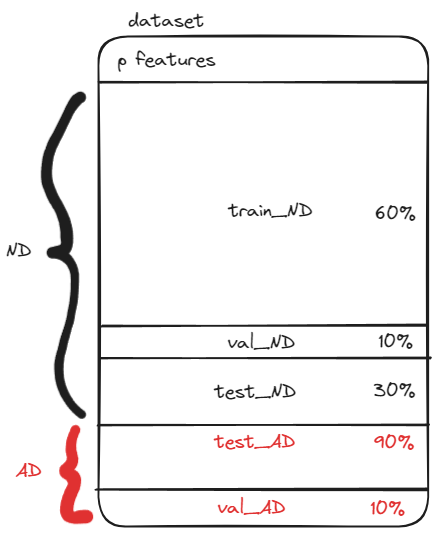

---
---


- **Autoencoder (semi-supervised approach)**
  Tipo di DL rete neurale.
  The approach learns the normal state of the supercomputer nodes and after the training phase can be used to discern anomalous conditions from normal behavior; in doing so it relies only on the availability of data characterizing only the normal state of the system. This is different from supervised methods that require datasets with many examples of anomalous states, which are in general very rare and/or hard to obtain.
  The learning task of the autoencoder is to reconstruct the initial input sequence; the internal representation of the autoencoder is constrained in such a way that the model cannot simply learn an identity function (e.g., by projecting the input data on a lower-dimension latent space).
  Adopting a semi-supervised approach proved to lead to inaccurate detection rates (with very high number of false positive).
  Un autoencoder è una rete neurale che ha come obiettivo di comprimere i dati di input in una rappresentazione a bassa dimensionalità e poi ricostruirli come output. L'autoencoder è formato da tre componenti principali:
	  - Encoder: una rete neurale connessa che parte dai dati di input e genera il codice attraverso la compressione.
	  - Codice: una compressione con perdita dei dati di input, chiamata anche "rappresentazione nello spazio latente".
	  - Decoder: una rete neurale connessa, tipicamente l'immagine speculare dell'encoder, che prende il codice e genera l'output.
   L'autoencoder viene usato per ridurre la dimensionalità dei dati, cioè per selezionare le caratteristiche più rilevanti e ridurre il rumore. Questo può migliorare le prestazioni degli algoritmi di apprendimento automatico che usano i dati compressi come input.
   
   ![Pasted image 20231015184216.png](<attachment:Pasted image 20231015184216.png>)
   


- **ExaMon**
  is a holistic framework for HPC facility monitoring and maintenance. It uses the MQTT protocol (publish-subscribe).
  At the lowest level, there are collector components (MQTT publishers) to read the data from several sensors scattered across the system and deliver them, in a standardized format, to a specific MQTT subscriber (MQTT2Kairos), implemented to bridge the collectors and the DB.
  There are a few hundreds of metrics collected on each computing nodes, plus dozens covering the racks and rooms.
  Several collectors:
	  - HW resources: PMU, IPMI, GPU, I2C, PMBUS, CPU load of all the cores in the supercomputing nodes, CPU clock, instructions per second, memory accesses (bytes written and read), fan speed, the temperature of the room hosting the system racks, power consumption (at different levels), etc.
	  - job dispatcher (the SW component that handles users requests and decides when each job should start and which resources to allocate), in particular **Slurm**: data regards the job request (job id, job name, job user, job partition/queue) and the requested resources (number of requested nodes, requested cores, requested GPUs and/or other HW accelerators, requested memory, requested wall-time), submission time, execution start time, end time, the set of nodes actually used along with the cores.
	  - SW diagnostic tools, **Nagios**: monitors and visualizes critical IT infrastructure components, providing historical logs of variations in the state of each monitored component, and sends alerts to the management staff, which are then handled by automated scripts that mark the node status depending on the severity of the alert (”Normal”, ”Warning” and ”Critical”). – If the alarm was real, the involved computing nodes have to be removed from production (“*drained*”). This action is registered in Nagios by the "DOWN+DRAIN" state of the node.
	 The data sampling frequency is **15 minutes**.


- **Detecting Anomalies with Nagios** (year 2021)
  An HPC node is put in "DOWN+DRAIN" state when is detached from production, that is only after a system administrator notices the issue; then, when the issue is solved, the node is reactivated. This procedure has a twofold implication:
  i) there is an implicit delay between the insurgence of an anomalous situation and the corresponding labeling;
  ii) labels indicating anomalies are associated to nodes which are in idle state (not only in actual error state), as, during the maintenance performed by system administrator to identify and fix the source of the issue, the node is idle (because no new jobs are submitted on the node). It is required that the model do not simply learn that Nagios fault equals to idleness.
   
   ![Pasted image 20231014195922.png](<attachment:Pasted image 20231014195922.png>)
   
   This approach combines two DL models:
   1) semi-supervised autoencoder deep neural networks. 
      It's trained using only normal data; the network can be used for anomaly detection by observing its reconstruction error computed on new data: if it is greater than a threshold, the new sample is classified as anomalous, normal otherwise.
   2) supervised neural network composed by an autoencoder (distinct from the semi-supervised one) and a series of classification layers.
      The autoencoder is pre-trained in an unsupervised manner with both normal and anomalous data points.
      The two classification layers are trained in supervised manner.
   The two are trained separately, they both produce an anomaly signal (0-normal, 1-faulty) that is combined in a logic-OR fashion (if both signals are normal the output is normal; or else is anomalous). 
   Both models can very well understand if the anomaly has happened, given them all the dataset (mainly recognizing the idle state of the node), and verifying the results comparing them with the Nagios signal.
   The main purpose is to detect in advance the insurgence of anomalies. When the model raises a (FP-Pre) False Positive in the period preceding the Nagios annotated label (two hours earlier), it means that the model have detected in advance the anomaly. With the semi-supervised approach (with variable threshold), while the overall number of false positives diminishes, the FP-Pre actually augments, suggesting that this semi-supervised network might actually anticipate the labels generated by Nagios. The main issue is that the not all false positives before the failures are consecutive, and thus are not used to signal anomalies.
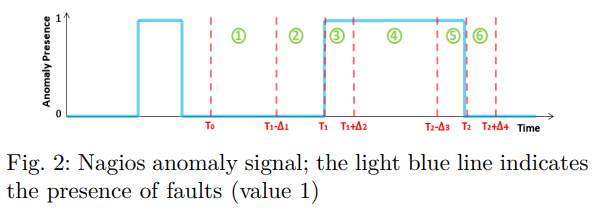
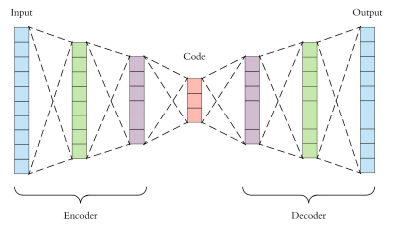